#**MAFAT Radar Challenge - Baseline Model**

In this notebook, a Convolutional Neural Network (CNN) baseline model is presented. 

The model is trained on the training and auxiliary datasets.   
In the end, a submission file with predictions for the public test set is being created and downloaded.

The raw input for the model is the segments I/Q matrices.   
Note that this is a simplistic baseline model. The model should only be used as a boilerplate code to boost development and to accelerate participants' orientation phase. Participants are encouraged to explore different, more creative, approaches, such as data augmentation, unsupervised pre-training/autoencoders, RNNs/transformers, signal processing, feature engineering, transfer learning, etc.   
   
To learn more about signals, I/Q, Doppler and other terms please go to [Resources](https://competitions.codalab.org/competitions/25389#learn_the_details-resources) on the competition website.    
Please read the [Descriptive Statistics notebook](https://colab.research.google.com/drive/11Lzihg2vKIbo4KAIIJxW5CRZIncoWgtL?usp=sharing) to get familiar with the data.
   
Submissions are evaluated on the area under the Receiver Operating Characteristic Curve ([ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)).   
**The baseline model final result on the public test set is:   
 0.73 ROC AUC.**

[Competition website](https://competitions.codalab.org/competitions/25389)   
[MAFAT Challenge homepage](https://mafatchallenge.mod.gov.il/)

# Helpers

No need to run these helpers blocks. Leaving them here because they have proved to be quite useful during normal development flow. 

For debug, add `ipdb.set_trace()` inside a cell that you want to debug.

The reload, in case there was a change in the experiment utils file, rerun the cell which imports the module, and then run the reload command below.

## Debugging

In [ ]:
!pip install ipdb -q

In [ ]:
import ipdb

## Reload a module

In [ ]:
reload(utils)

# **Setup**

In [1]:
%load_ext autoreload
%autoreload 2

on local, the notebook will open on the path it is stored on. 
on colab, the pwd path is always '/content'

In [2]:
import configparser
import os.path
from os import path

WANDB_enable = False
creds_path_ar = ["../credentials.ini","credentials.colab.ini"]
root_path = ""
data_path = ""

for creds_path in creds_path_ar:
  if path.exists(creds_path):
      config_parser = configparser.ConfigParser()
      config_parser.read(creds_path)
      root_path = config_parser['MAIN']["PATH_ROOT"]
      data_path = config_parser['MAIN']["PATH_DATA"]
      WANDB_enable = config_parser['MAIN']["WANDB_ENABLE"] == 'TRUE'
      ENV = config_parser['MAIN']["ENV"]
      break


In [ ]:
if ENV=="COLAB":
  !pip install tensorflow-determinism
  !pip install --upgrade wandb


In [4]:
if ENV=="COLAB":
  from google.colab import drive
  mount_path = '/content/gdrive/'
  drive.mount(mount_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [5]:
if root_path is not '':
  pass
elif os.path.isfile('path'):
  root_path = open('path', 'r').read()
else:
  root_path = input()
  path_file = open("path", "w")
  path_file.write(root_path)
  path_file.close()

In [6]:
cd {root_path}

/content/gdrive/My Drive/WORK/ML/develop/MAFAT/sota-mafat-radar


In [7]:
if ENV=="COLAB" and os.path.isfile('/content/credentials.colab.ini'):
  !cp /content/credentials.colab.ini credentials.ini 

In [8]:
import os
import sys
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from importlib import reload  #use 'reload' to reload module manually if it was changed

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

from src.utils import experiment_utils as utils

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.compat.v1.reset_default_graph()

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

tf.__version__


'2.3.0'

In [9]:
WANDB_enable = False

if WANDB_enable:
  !wandb login {utils.config_parser['DEFAULT']["WANDB_LOGIN"]}
  import wandb
  from wandb.keras import WandbCallback


In [10]:
# Set and test path to competition data files

if data_path is '':
  data_path = os.path.join(os.getcwd(),"data") 

try:
  file_path = 'MAFAT RADAR Challenge - Training Set V1.csv'
  with open(f'{data_path}/{file_path}') as f:
    f.readlines()
  print(colored('Everything is setup correctly', color='green'))
except:
  print(colored('Please mount drive and set data_path correctly',
                color='red'))

Everything is setup correctly


## **Data Preprocessing**
**The preprocessing main steps:**   
1. Applying [DFT](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) (Discrete Fourier transform) by using the fast Fourier transform algorithm ([FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform)) and [Hann function](https://www.mathworks.com/help/signal/ref/hann.html) to smooth the I/Q matrix. Afterward, calculating the absolute value of the I/Q matrix complex numbers.   
More information about Windowing and Hann function:   
[Wikipedia Hann](https://en.wikipedia.org/wiki/Hann_function#:~:text=The%20Hann%20function%20of%20length,can%20be%20even%20or%20odd.)   
[Wikipedia Window function](https://en.wikipedia.org/wiki/Window_function)   
2. Set max value on the center of the target's mass.   
The doppler burst is a vector (1 x 32) that marks the center of the target's mass on each I/Q matrix in every time unit (32 time-units).   
The preprocess sets the maximum value of each I/Q matrix in-place of the values at the center of the target's mass.
3. Normalization - Transforming I/Q matrix values to standardized values.   
Subtraction of the mean and division by the standard deviation.

**Preprocessing main steps explained:**   
The DFT converts a signal from its original domain (often time or space) to a representation in the frequency domain and vice versa.   
The I/Q matrix in this challenge is being converted from the velocity domain to the frequency domain.
Windows (like "Hann") are used to reduce spectral leakage when performing a Fourier Transform on time data and converting it into the frequency domain.

The purpose of switching the values of the center of the target's mass in the I/Q matrix with the max value of the matrix is to enhance this part of the matrix and focus the model on this part.


Finally, the normalization is used for scaling all the I/Q matrices.

* *Note: the target_type lables are strings ("human" and "animal"), the data_preprocess function replaces them to "human" = 1 and "animal" = 0.*   
   


**The FFT Process Explained:**   
The IQ matrix contains 32 x 128 elements being 128 I/Q time data samples within a single radar processing time frame and 32 consecutive such time units. The X-axis represents the pulse transmission time, also known as “slow-time”. The Y-axis represents the reception time of signals with respect to pulse transmission time divided into 128 equal sized bins, also known as “fast-time”. The reason FFT is performed on the ‘fast time’ axis (i.e. 128 samples) rather than on the ‘slow time’ axis (i.e. 32 samples) is a matter of scale. An underlying assumption for an effective FFT analysis is that ‘acceleration’ during the time frame represented by the data is very low. Given the type of motion presented by humans and animals only the ‘fast time’ axis complies with this assumption.
Therefore, FFT processing should be applied over the dimension of 128 I/Q time samples to get the frequency content of the returned radar signal at each time frame. A spectrogram (as shown in the samples) is generated by attaching together 32 consecutive FFT results (please note that besides FFT processing some additional manipulation is required to properly display a spectrogram – like taking a LOG of the absolute value and passing a threshold – this is well detailed in the ‘Processing’ section of the competition notebook). Therefore, a spectrogram would eventually provide a display of how the frequency content of the returned signal is changing along time.

### **Splitting the Training set**

The functions below split the training set into Train and Validation sets.

* Validation Set.   
The validation set is constructed from segments from geolocation_ids 1 and 4.   
These geolocations' target_type distributions are balanced.
To create a fair representation of the test set   
(one segment form each track) every sixth segment was taken to the validation set.   
The reason is that approximately 75% of the tracks have less than 6 segments (see the [Descriptive Statistics notebook](https://colab.research.google.com/drive/11Lzihg2vKIbo4KAIIJxW5CRZIncoWgtL?usp=sharing)),   
it guarantees that most of the segments in the validation set are not from the same track.   
   
* Adding "human" segments to the training set.   
The training set is imbalanced (more animals than humans, see the [Descriptive Statistics notebook](https://colab.research.google.com/drive/11Lzihg2vKIbo4KAIIJxW5CRZIncoWgtL?usp=sharing).   
One can address this issue by taking segements of humans from the "Auxiliary Experiment Set".   
The first 3 segments from each track are taken into the training set (or less if the track is shorter than 3 segments).

## **Model**

### **CNN Model**
The model has two convolutional layers, both followed by max-pooling layers.    
Those layers are followed by 2 fully-connected (dense) layers, activated with a ReLU function and regularized with   
L2 regularization, followed by a final output layer with a single neuron with a Sigmoid activation function,   
used for final binary classification.

**Model Architecture**   
   
![](https://drive.google.com/uc?export=view&id=1wsJBHbghEPGT0s1QQG6BHl7MS3Yo0o4i)

In [11]:
# Building the model
def create_model(input_shape, init):
  """
  CNN model.

  Arguments:
    input_shape -- the shape of our input
    init -- the weight initialization

  Returns:
    CNN model    
  """
  model = Sequential()
  model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(32, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(1, activation='sigmoid', kernel_initializer = init))
  return model

## **Loading Data**

In [12]:
# Loading and preparing the data

# Loading Auxiliary Experiment set - can take a few minutes
experiment_auxiliary = 'MAFAT RADAR Challenge - Auxiliary Experiment Set V2'
experiment_auxiliary_df = utils.load_data(experiment_auxiliary, folder=data_path )
experiment_auxiliary_df['date_index'].shape

(49071,)

In [13]:
# Taking sample from the Auxiliary Experiment set
train_aux = utils.aux_split(experiment_auxiliary_df)
train_aux['date_index'].shape

(221,)

In [14]:
# The function append_dict is for concatenating the training set 
# with the Auxiliary data set segments

def append_dict(dict1, dict2):
  for key in dict1:
    dict1[key] = np.concatenate([dict1[key], dict2[key]], axis=0)
  return dict1

---

# Creating Inner test set


In [ ]:
# Training set
train_path = 'MAFAT RADAR Challenge - Training Set V1'
training_df = utils.load_data(train_path, folder=data_path )
print(f"real dataset({training_df['date_index'].shape})",end='')

# Adding segments from the experiment auxiliary set to the training set
train_df = append_dict(training_df, train_aux)
total_number_samples = train_df['date_index'].shape[0]
print(f" + aux dataset({train_aux['date_index'].shape}) = full train({total_number_samples})")

# Preprocessing and split the data to training and validation
train_df = utils.data_preprocess(train_df.copy())
train_x, train_y, valtest_x, valtest_y, valtest_ar = utils.split_train_val(train_df)

valtest_ar_idx = list(np.where(valtest_ar==True)[0])
val_idx,test_idx,mask = utils.splitArrayBy(valtest_ar_idx,[2,1])

is_validation_ar = np.array([False]*total_number_samples)
is_validation_ar[list(val_idx)]=True
is_test_ar = np.array([False]*total_number_samples)
is_test_ar[list(test_idx)]=True

val_y = valtest_y[mask==0]
val_x = valtest_x[mask==0,:]
test_y = valtest_y[mask==1]
test_x = valtest_x[mask==1,:]

train_df_t = train_df.copy()
del train_df_t['doppler_burst']
del train_df_t['iq_sweep_burst']
train_dff = pd.DataFrame(train_df_t)
train_dff['is_validation']=is_validation_ar
train_dff['is_test']=is_test_ar

val_y =  val_y.astype(int)
train_y =train_y.astype(int)
test_y =test_y.astype(int)
train_x = train_x.reshape(list(train_x.shape)+[1])
val_x = val_x.reshape(list(val_x.shape)+[1])
test_x = test_x.reshape(list(test_x.shape)+[1])

print(f"train:{train_x.shape[0]}")
print(f"val:{val_x.shape[0]}")
print(f"test:{test_x.shape[0]}")

# Augmentations


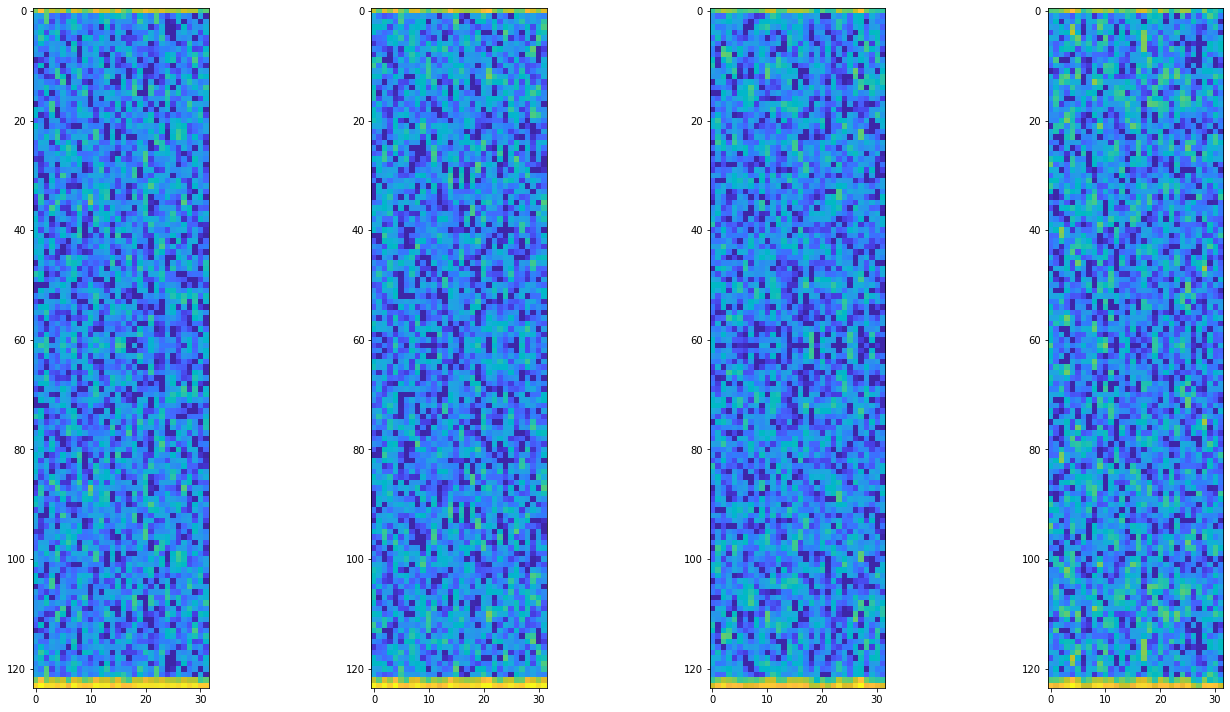

In [19]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from numpy import expand_dims
import random

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 2
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img


datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=0.05,
    preprocessing_function=add_noise,
)
samples = expand_dims(train_x[0,:], 0)

it = datagen.flow(samples, batch_size=1)

fig, axarr = plt.subplots(1, 4,figsize=(20, 10))


for i in range(4):
  # define subplot
  ax1 = axarr[i]
  # generate batch of images
  batch = it.next()
  # convert to unsigned integers for viewing
  image = np.squeeze(batch[0].astype('uint8'))  # squeeze: (128,32,1) => (128,32)
  utils.plot_spectrogram(
      image,
      None, 
      color_map_path='data/cmap.npy',
      ax=ax1
      )
fig.subplots_adjust(top=0.88)
fig.tight_layout()
plt.show()

In [20]:
# Model configuration:
batch_size = 16
img_width, img_height = 126, 32
loss_function = BinaryCrossentropy()
no_epochs = 30
optimizer = Adam(learning_rate = 0.001)
input_shape = (img_width, img_height, 1)

init = tf.keras.initializers.GlorotNormal(seed = 0)

# Creating and running the model
model = create_model(input_shape, init)  
model.compile(loss=loss_function, optimizer=optimizer, metrics=[AUC(), 'accuracy'])

In [21]:
# Model fit

callbacks = []
if WANDB_enable:
  wandb.init(project="mafat",name="data_aug")
  callbacks.append(WandbCallback())

history = model.fit(
    datagen.flow(train_x, train_y, batch_size=batch_size),
    epochs = no_epochs,
    validation_data = (val_x, val_y), callbacks=callbacks)

Epoch 1/30
411/411 [==============================] - 8s 21ms/step - loss: 0.6643 - auc_1: 0.8537 - accuracy: 0.8761 - val_loss: 0.7929 - val_auc_1: 0.6860 - val_accuracy: 0.6359
Epoch 2/30
411/411 [==============================] - 8s 20ms/step - loss: 0.3085 - auc_1: 0.9102 - accuracy: 0.8968 - val_loss: 0.6494 - val_auc_1: 0.7398 - val_accuracy: 0.6505
Epoch 3/30
411/411 [==============================] - 8s 19ms/step - loss: 0.2767 - auc_1: 0.9266 - accuracy: 0.8994 - val_loss: 0.6152 - val_auc_1: 0.8061 - val_accuracy: 0.7233
Epoch 4/30
411/411 [==============================] - 8s 20ms/step - loss: 0.2583 - auc_1: 0.9326 - accuracy: 0.9070 - val_loss: 0.6112 - val_auc_1: 0.8086 - val_accuracy: 0.6990
Epoch 5/30
411/411 [==============================] - 8s 19ms/step - loss: 0.2565 - auc_1: 0.9324 - accuracy: 0.9044 - val_loss: 0.6786 - val_auc_1: 0.7872 - val_accuracy: 0.6893
Epoch 6/30
411/411 [==============================] - 8s 20ms/step - loss: 0.2483 - auc_1: 0.9362 - accur

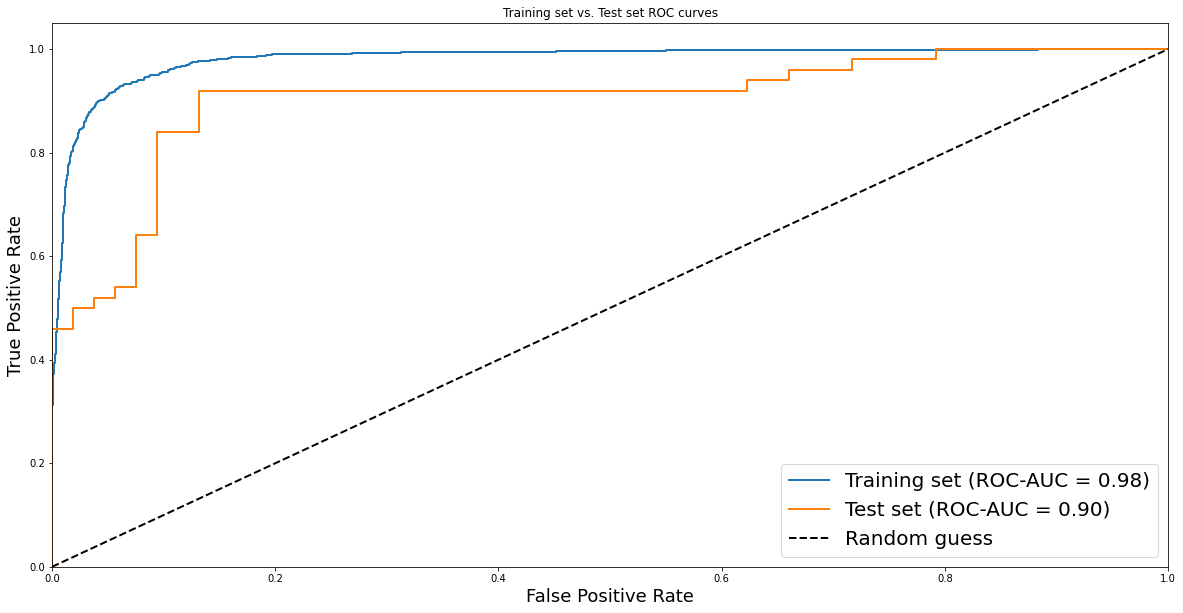

In [22]:
pred = [model.predict(train_x), model.predict(test_x)]
actual = [train_y, test_y]
utils.stats(pred, actual, mode="Test")

# **Final Submission File**

Create a CSV submission file , zip and download it.

In [ ]:
# Creating DataFrame with the probability prediction for each segment
submission =  pd.DataFrame()
submission['segment_id'] = test_df['segment_id']
submission['prediction'] = model.predict(test_x)
submission['prediction'] = submission['prediction'].astype('float')

# Save submission
submission.to_csv('submission.csv', index=False)

In [ ]:
# Download zip file
from zipfile import ZipFile
from google.colab import files

with ZipFile('submission.zip', 'w') as myzip:
  myzip.write('submission.csv')

files.download('submission.zip')


In [15]:
# Training set
train_path = 'MAFAT RADAR Challenge - Training Set V1'
training_df = utils.load_data(train_path, folder=data_path )
print(f"real dataset({training_df['date_index'].shape})",end='')

# Adding segments from the experiment auxiliary set to the training set
train_df = append_dict(training_df, train_aux)
total_number_samples = train_df['date_index'].shape[0]
print(f" + aux dataset({train_aux['date_index'].shape}) = full train({total_number_samples})")

# Preprocessing and split the data to training and validation
train_df = utils.data_preprocess(train_df.copy())
train_x, train_y, valtest_x, valtest_y, valtest_ar = utils.split_train_val(train_df)

valtest_ar_idx = list(np.where(valtest_ar==True)[0])
val_idx,test_idx,mask = utils.splitArrayBy(valtest_ar_idx,[2,1])

is_validation_ar = np.array([False]*total_number_samples)
is_validation_ar[list(val_idx)]=True
is_test_ar = np.array([False]*total_number_samples)
is_test_ar[list(test_idx)]=True

val_y = valtest_y[mask==0]
val_x = valtest_x[mask==0,:]
test_y = valtest_y[mask==1]
test_x = valtest_x[mask==1,:]

train_df_t = train_df.copy()
del train_df_t['doppler_burst']
del train_df_t['iq_sweep_burst']
train_dff = pd.DataFrame(train_df_t)
train_dff['is_validation']=is_validation_ar
train_dff['is_test']=is_test_ar

val_y =  val_y.astype(int)
train_y =train_y.astype(int)
test_y =test_y.astype(int)
train_x = train_x.reshape(list(train_x.shape)+[1])
val_x = val_x.reshape(list(val_x.shape)+[1])
test_x = test_x.reshape(list(test_x.shape)+[1])

print(f"train:{train_x.shape[0]}")
print(f"val:{val_x.shape[0]}")
print(f"test:{test_x.shape[0]}")

real dataset((6656,)) + aux dataset((221,)) = full train(6877)
train:6568
val:206
test:103


In [16]:
train_dff

,segment_id,track_id,geolocation_type,geolocation_id,sensor_id,snr_type,date_index,target_type,is_validation,is_test
0,0,11,C,1,1,HighSNR,27,0,True,False
1,1,16,C,1,1,HighSNR,27,0,False,False
2,2,16,C,1,1,HighSNR,27,0,False,False
3,3,29,C,1,1,HighSNR,27,0,False,False
4,4,29,C,1,1,HighSNR,27,0,False,False
...,...,...,...,...,...,...,...,...,...,...
6872,10659,261158,D,6,10,LowSNR,2,1,False,False
6873,10661,261192,D,6,10,LowSNR,2,1,False,False
6874,10745,269230,D,7,12,LowSNR,3,1,False,False
6875,10771,269476,D,7,12,LowSNR,3,1,False,False
